# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [5]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [6]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1704614948.zip, parmi :

data_BEN_1704614948.zip
data_BEN_1704518050.zip


In [7]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-01-07.zip, parmi 

File-Export-2020-08-03-to-2024-01-07.zip
File-Export-2020-08-03-to-2024-01-06.zip


In [8]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_12baa4ce-79a5-40f8-ad40-74308f7c2c26.zip, parmi :

polar-user-data-export_872b7f7c-c5e0-4b44-b031-f8e8821babae.zip
polar-user-data-export_12baa4ce-79a5-40f8-ad40-74308f7c2c26.zip


In [9]:
# copie les trois fichiers sélectionnés dans le répertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight_imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2024-01-07.zip, data_BEN_1704614948.zip, polar-user-data-export_12baa4ce-79a5-40f8-ad40-74308f7c2c26.zip


In [10]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)', 'Masse osseuse (kg)', 'Masse musculaire (kg)', 'Hydratation (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)

os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 
                            'Gras (kg)' : 'Masse_Grasse',
                            'Masse osseuse (kg)' : 'Masse_Osseuse',
                            'Masse musculaire (kg)' : 'Masse_Musculaire',
                            'Hydratation (kg)' : 'Masse_Hydrique'
                            }, 
                 inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]

subset = ['Masse_Totale', 'Masse_Grasse']
df_weight.dropna(subset = subset, inplace=True)

# df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * (df_weight['Masse_Totale'] - df_weight['Masse_Grasse'])  # Katch Mac Ardle

df_weight.sort_index(inplace=True)

In [11]:
# forward propagate actual values into NaN
df_weight.fillna(method="ffill", inplace=True)

In [12]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-12-24,72.307500,11.954167,3.018333,57.321667,40.469167,0.165324,1673.632000
2023-12-25,73.006000,12.387000,3.029000,57.574000,40.636000,0.169671,1679.370400
2023-12-26,73.503333,12.770833,3.033333,57.685000,40.679167,0.173745,1681.822000
2023-12-27,73.326667,12.425833,3.042500,57.842500,40.896667,0.169459,1685.458000
2023-12-28,72.683333,12.099167,3.027500,57.540000,40.657500,0.166464,1678.618000
2023-12-29,73.100000,12.794000,3.010000,57.278000,40.282000,0.175021,1672.609600
2023-12-30,74.404000,13.175000,3.056000,58.158000,41.076000,0.177074,1692.546400
2023-12-31,73.695000,12.560833,3.055000,58.064167,41.090833,0.170443,1690.498000
2024-01-01,75.071667,11.675000,3.190000,60.191667,43.518333,0.155518,1739.368000


In [13]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-12-24,71.565828,11.780835,2.990198,56.779866,39.959571,0.164616,1661.355842
2023-12-25,71.836923,11.847788,3.000174,56.974128,40.140786,0.164910,1665.765327
2023-12-26,72.208828,12.015764,3.009793,57.168842,40.304810,0.166368,1670.170185
2023-12-27,72.462066,12.094168,3.018007,57.335342,40.456333,0.166864,1673.946585
2023-12-28,72.571553,12.139764,3.020947,57.396222,40.507844,0.167245,1675.326651
2023-12-29,72.806910,12.316407,3.022733,57.452364,40.531940,0.169140,1676.594879
2023-12-30,73.190119,12.515143,3.030952,57.628452,40.670929,0.170965,1680.579486
2023-12-31,73.388333,12.601810,3.036190,57.734524,40.759738,0.171697,1682.988914
2024-01-01,73.683429,12.500095,3.059190,58.108476,41.171500,0.169675,1691.560000


In [14]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

In [15]:
# df_food.tail(15)

In [16]:
# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum(numeric_only=True)

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

In [17]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-12-23,2827.7,87.2,306.3,199.5
2023-12-24,3232.7,130.4,415.9,93.5
2023-12-25,3369.1,120.8,341.6,168.8
2023-12-26,1162.2,11.1,137.7,141.0
2023-12-27,1653.4,52.3,122.9,184.1
2023-12-28,2395.2,96.7,311.3,70.2
2023-12-29,3766.6,145.2,493.7,128.9
2023-12-30,1680.1,48.3,144.7,157.8
2023-12-31,2823.0,96.3,222.4,177.5


In [18]:
# MAX_CAL = 1800.0
# PERIODE = 22
# n_jours = 7
# target = (MAX_CAL*PERIODE - df_food['Calories'][n_jours-PERIODE:].sum())/n_jours
# avg = df_food['Calories'][n_jours-PERIODE:].mean()

# print(f'Moyenne {PERIODE-n_jours} derniers jours = {avg:.0f} kcals/jour')
# print(f'Target quotidienne sur les {n_jours} prochains jours pour tenir {MAX_CAL:.0f} kcals quotidiennes = {target:.0f} kcals/jour')

In [19]:
# # plot data
# fig, ax = plt.subplots(figsize=(16, 6))

# tick_label = list(df_food.index[n_jours-PERIODE:]) + [ df_food.index[-1] + datetime.timedelta(days=d) for d in range(1,n_jours+1 )]
# listcals = list(df_food['Calories'][n_jours-PERIODE:]) + [ target ] * n_jours

# colors = [ 'blue'] * (PERIODE-n_jours) + ['green'] * n_jours
# sns.barplot(x=tick_label, y=listcals, ax=ax, palette=colors)

# # annotate
# ax.bar_label(ax.containers[0], label_type='center', fmt="%.0f")
# ax.tick_params(labelrotation=45)

# # pad the spacing between the number and the edge of the figure
# ax.margins(y=0.1)

# ax.set_ylabel('calories')
# ax.set_title(f'objectif quotidien {MAX_CAL:.0f} kcals - target {n_jours} prochains jours = {target:.0f} kcals')

# ax.hlines(y=avg, xmin=0, xmax=PERIODE-n_jours-1, colors=['red'])
# ax.hlines(y=MAX_CAL, xmin=0, xmax=PERIODE, colors=['green'])

# plt.show()

In [20]:
# df_food.rolling(window=7).mean().tail(15)

In [21]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [22]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

100%|██████████| 1828/1828 [01:02<00:00, 29.44it/s]


In [23]:
df_exos.tail(15)

,exo_duree,exo_cals_bruts
2023-12-18,3120.728,238.0
2023-12-19,1560.721,204.0
2023-12-20,1920.578,154.0
2023-12-22,3127.078,341.0
2023-12-24,3077.328,207.0
2023-12-25,3121.531,392.0
2023-12-26,1636.907,290.0
2023-12-27,6123.605,581.0
2023-12-29,3180.584,244.0
2023-12-30,1680.720,261.0


In [24]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight_imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [25]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2024-01-08,0,0


In [26]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [27]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
2023-12-19,1560.721,204.0
2023-12-20,1920.578,154.0
2023-12-22,3127.078,341.0
2023-12-24,3077.328,207.0
2023-12-25,3121.531,392.0
2023-12-26,1636.907,290.0
2023-12-27,6123.605,581.0
2023-12-29,3180.584,244.0
2023-12-30,1680.720,261.0
2023-12-31,6005.953,671.0


In [28]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
2023-12-19,2814.528143,281.428571
2023-12-20,2623.438857,255.285714
2023-12-22,2830.045857,269.285714
2023-12-24,2755.378429,270.285714
2023-12-25,2978.368429,296.000000
2023-12-26,2509.267286,260.857143
2023-12-27,2938.249714,309.857143
2023-12-29,3169.658714,315.571429
2023-12-30,3135.393286,330.857143
2023-12-31,3546.661143,378.000000


In [29]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [30]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [31]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [32]:
# df_all.head(20)
# df_all.describe(include='all')
# df_all.info()

In [33]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-12-23,71.721538,11.783846,2.998462,56.925385,40.103077,0.164300,1664.654154,2827.7,87.2,306.3,199.5,0.000,0.0,0.000000,1664.654154,1163.045846
2023-12-24,72.307500,11.954167,3.018333,57.321667,40.469167,0.165324,1673.632000,3232.7,130.4,415.9,93.5,3077.328,207.0,147.389877,1821.021877,1411.678123
2023-12-25,73.006000,12.387000,3.029000,57.574000,40.636000,0.169671,1679.370400,3369.1,120.8,341.6,168.8,3121.531,392.0,331.326311,2010.696711,1358.403289
2023-12-26,73.503333,12.770833,3.033333,57.685000,40.679167,0.173745,1681.822000,1162.2,11.1,137.7,141.0,1636.907,290.0,258.136734,1939.958734,-777.758734
2023-12-27,73.326667,12.425833,3.042500,57.842500,40.896667,0.169459,1685.458000,1653.4,52.3,122.9,184.1,6123.605,581.0,461.543067,2147.001067,-493.601067
2023-12-28,72.683333,12.099167,3.027500,57.540000,40.657500,0.166464,1678.618000,2395.2,96.7,311.3,70.2,0.000,0.0,0.000000,1678.618000,716.582000
2023-12-29,73.100000,12.794000,3.010000,57.278000,40.282000,0.175021,1672.609600,3766.6,145.2,493.7,128.9,3180.584,244.0,182.427369,1855.036969,1911.563031
2023-12-30,74.404000,13.175000,3.056000,58.158000,41.076000,0.177074,1692.546400,1680.1,48.3,144.7,157.8,1680.720,261.0,228.075271,1920.621671,-240.521671
2023-12-31,73.695000,12.560833,3.055000,58.064167,41.090833,0.170443,1690.498000,2823.0,96.3,222.4,177.5,6005.953,671.0,553.487829,2243.985829,579.014171
2024-01-01,75.071667,11.675000,3.190000,60.191667,43.518333,0.155518,1739.368000,2568.9,73.7,265.0,163.5,0.000,0.0,0.000000,1739.368000,829.532000


In [34]:
file_save = os.getcwd() + "/data/dataset.csv"

with open(file_save, 'w') as f:
    df_all.to_csv(file_save)

In [35]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-12-23,71.465042,11.680811,2.990579,56.778200,39.982119,0.163451,1661.339385,2155.985714,72.628571,193.900000,186.671429,1389.872143,133.857143,107.219961,1768.559346,387.426368
2023-12-24,71.565828,11.780835,2.990198,56.779866,39.959571,0.164616,1661.355842,2180.514286,70.285714,217.900000,171.900000,1829.490429,163.428571,128.275658,1789.631500,390.882786
2023-12-25,71.836923,11.847788,3.000174,56.974128,40.140786,0.164910,1665.765327,2411.214286,77.542857,250.585714,170.185714,1829.605143,185.428571,150.114160,1815.879487,595.334799
2023-12-26,72.208828,12.015764,3.009793,57.168842,40.304810,0.166368,1670.170185,2330.757143,71.914286,246.714286,166.828571,1840.488857,197.714286,162.108448,1832.278632,498.478510
2023-12-27,72.462066,12.094168,3.018007,57.335342,40.456333,0.166864,1673.946585,2320.871429,73.185714,242.028571,169.300000,2440.921286,258.714286,211.311497,1885.258082,435.613347
2023-12-28,72.571553,12.139764,3.020947,57.396222,40.507844,0.167245,1675.326651,2331.100000,75.285714,259.828571,147.785714,2440.921286,258.714286,211.311497,1886.638148,444.461852
2023-12-29,72.806910,12.316407,3.022733,57.452364,40.531940,0.169140,1676.594879,2629.557143,91.957143,304.200000,140.857143,2448.565000,244.857143,197.260480,1873.855359,755.701784
2023-12-30,73.190119,12.515143,3.030952,57.628452,40.670929,0.170965,1680.579486,2465.614286,86.400000,281.114286,134.900000,2688.667857,282.142857,229.842661,1910.422147,555.192139
2023-12-31,73.388333,12.601810,3.036190,57.734524,40.759738,0.171697,1682.988914,2407.085714,81.528571,253.471429,146.900000,3107.042857,348.428571,287.856654,1970.845569,436.240146
2024-01-01,73.683429,12.500095,3.059190,58.108476,41.171500,0.169675,1691.560000,2292.771429,74.800000,242.528571,146.142857,2661.109857,292.428571,240.524324,1932.084324,360.687104


## Visual Management et Prédictions Bayesiennes

In [36]:
columns_to_keep = ['Masse_Totale', 'Masse_Grasse', 'Masse_Musculaire', 'BMR', 'Calories', 'exo_cals_nets']

df_mg = df_all[columns_to_keep].copy()

df_mg['next_day_MT'] = df_mg['Masse_Totale'].shift(-1)
df_mg['next_day_MG'] = df_mg['Masse_Grasse'].shift(-1)
df_mg['next_day_MM'] = df_mg['Masse_Musculaire'].shift(-1)

df_mg['Proxy_Cal_Def'] = df_mg['Calories'] - df_mg['BMR'] - df_mg['exo_cals_nets']

df_mg.dropna(inplace=True)

start_date = datetime.date(year=2023, month=3, day= 1) # '2021-04-01' - début enregistrement masse musculaire en mars 2023
# end_date = '2023-12-31'

df_mg = df_mg.loc[(df_mg.index >= start_date)] # & (df_mg.index <= end_date)]

df_mg['var_MT'] = (df_mg['next_day_MT'] - df_mg['Masse_Totale']).copy()
df_mg['var_MG'] = (df_mg['next_day_MG'] - df_mg['Masse_Grasse']).copy()
df_mg['var_MM'] = (df_mg['next_day_MM'] - df_mg['Masse_Musculaire']).copy()

df_mg.drop(columns=['next_day_MT', 'next_day_MG', 'next_day_MM'], inplace=True)

df_mg

,Masse_Totale,Masse_Grasse,Masse_Musculaire,BMR,Calories,exo_cals_nets,Proxy_Cal_Def,var_MT,var_MG,var_MM
2023-03-04,70.656667,11.420000,56.258333,1649.512000,2271.1,0.000000,621.588000,1.223333,0.428571,0.755952
2023-03-05,71.880000,11.848571,57.014286,1666.678857,1774.3,353.867654,-246.246512,-0.850000,-0.924571,0.067714
2023-03-06,71.030000,10.924000,57.082000,1668.289600,1759.7,498.562450,-407.152050,1.155000,0.202667,0.904667
2023-03-07,72.185000,11.126667,57.986667,1688.860000,2516.4,979.099745,-151.559745,0.098333,-0.948333,0.970000
2023-03-08,72.283333,10.178333,58.956667,1711.468000,1658.9,336.012941,-388.580941,-0.124762,-0.044048,-0.073810
...,...,...,...,...,...,...,...,...,...,...
2024-01-01,75.071667,11.675000,60.191667,1739.368000,2568.9,0.000000,829.532000,-0.823333,0.853333,-1.568333
2024-01-02,74.248333,12.528333,58.623333,1703.152000,1645.5,0.000000,-57.652000,-0.874333,0.555667,-1.358333
2024-01-03,73.374000,13.084000,57.265000,1672.264000,1516.0,190.449082,-346.713082,-0.694909,-0.085818,-0.580455
2024-01-04,72.679091,12.998182,56.684545,1659.107636,1540.8,213.868631,-332.176267,0.376909,0.200818,0.164455


In [37]:
food_intake = 1700.0
exos_avg = 200.0

data_columns = [ 'Masse_Totale', 'Masse_Grasse', 'MG%', 'Masse_Musculaire' ]

horizon_past = 60 # nb jours dans le passé
horizon_futur = 30 # nb jours projection

In [38]:
# list_columns = ['Masse_Totale', 'Masse_Grasse', 'BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
# list_columns =['BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
list_columns =['Calories', 'exo_cals_nets', ]
X = df_mg[list_columns].to_numpy()

# y's
y = {}
y['Masse_Totale'] = df_mg['var_MT'].to_numpy()
y['Masse_Grasse'] = df_mg['var_MG'].to_numpy()
y['Masse_Musculaire'] = df_mg['var_MM'].to_numpy()

# modeles
modeles={}
scores={}
noises={}
daily_delta ={}

for name in [ 'Masse_Totale', 'Masse_Musculaire', 'Masse_Grasse']:
    brr = linear_model.BayesianRidge()
    brr.fit(X, y[name])
    modeles[name] = brr
    scores[name] = brr.score(X, y[name])
    noises[name] = np.sqrt(1/brr.alpha_)
    daily_delta[name] = brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    print(f'modele = {name}; score = {scores[name]}; noise = {noises[name]}; daily_delta = {daily_delta[name]}')
    
scores['MG%'] = 'n:a'

best_ever_mgp = np.min(df_all['MG%'])
date_best_ever_mgp = df_all['MG%'].idxmin()
print(f'Best ever MG% = {best_ever_mgp*100:.1f}% le {date_best_ever_mgp}')

best_ever_mg = np.min(df_all['Masse_Grasse'])
date_best_ever_mg = df_all['Masse_Grasse'].idxmin()
print(f'Best ever MG = {best_ever_mg:.1f}kg le {date_best_ever_mg}')

modele = Masse_Totale; score = 0.2370602157027465; noise = 0.7075956070378567; daily_delta = -0.16309686244518254
modele = Masse_Musculaire; score = 0.07005040195369516; noise = 0.7871086498486415; daily_delta = -0.09554038585993258
modele = Masse_Grasse; score = 0.1593902798081276; noise = 0.44641020974849477; daily_delta = -0.06279019585699841
Best ever MG% = 11.3% le 2021-10-04
Best ever MG = 7.5kg le 2021-10-04


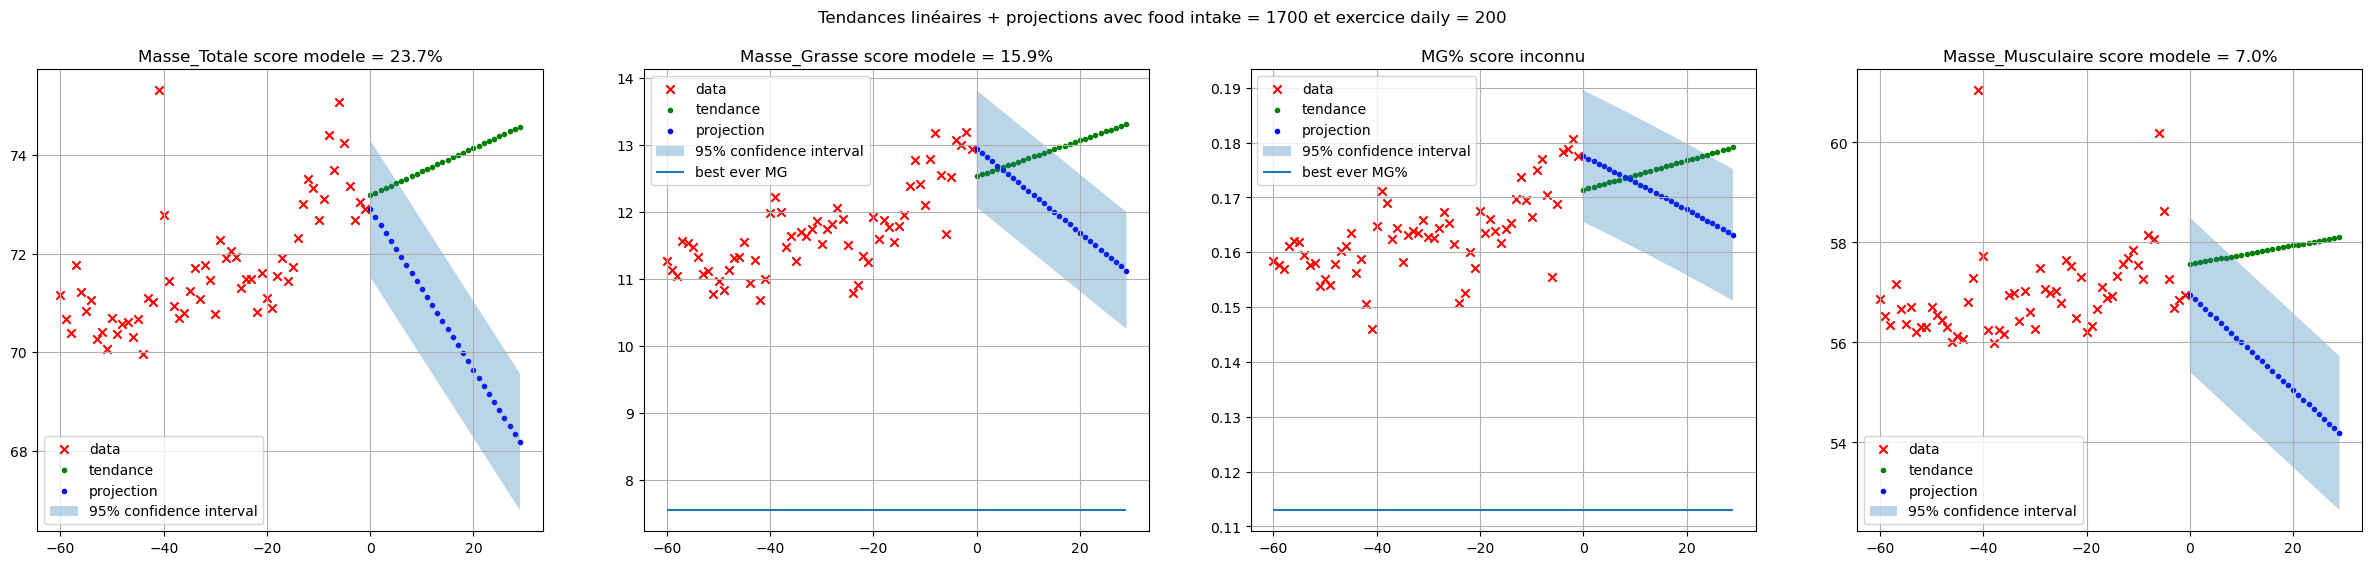

In [39]:
# Indicateurs Masse Totale, Masse Grasse, MG%, Masse Musculaire

X_past = np.array( [i for i in range(-horizon_past,0)] )
X_futur = np.array( [i for i in range(horizon_futur)] )
X = np.array([i for i in range(-horizon_past, horizon_futur)])

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30,6))

for i, name in enumerate(data_columns):
    
    # tendances
    brr = linear_model.BayesianRidge()
    # brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    data_past = df_all[name][-horizon_past:].to_numpy()
    brr.fit( X_past.reshape(-1,1), data_past )
    
    data_futur = brr.predict(X_futur.reshape(-1,1))
    
    std = np.sqrt(1/brr.alpha_)
   
    axs[i].scatter(X_past, data_past, marker='x', color='red', label='data')
    axs[i].scatter(X_futur, data_futur, marker='.', color='green', label='tendance')
    if name=='MG%':
        titre = name + ' score inconnu'
    else:
        titre = name + ' score modele = ' + f'{scores[name]*100:.1f}%'
    axs[i].set_title(titre)
    axs[i].grid(True)
    
    # predictions avec hypothèses food intake et exercices
    if name=='MG%':
        y_pred_mt = np.array([ df_all['Masse_Totale'][-1] + X_futur * daily_delta['Masse_Totale'] ]).reshape(-1,1)
        y_pred_mg = np.array([ df_all['Masse_Grasse'][-1] + X_futur * daily_delta['Masse_Grasse'] ]).reshape(-1,1)
        y_pred = np.array([ y_pred_mg[j] / y_pred_mt[j] for j in list(X_futur)]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = np.array(noises['Masse_Grasse'] / df_all['Masse_Totale'][-1])  # estime une std sur MG%
    else:
        last_y = data_past[-1]
        dd = daily_delta[name]
        y_pred = np.array([ last_y + X_futur * dd ]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = noises[name]
    
    y_min = np.squeeze(y_pred - 1.96 * y_std)
    y_max = np.squeeze(y_pred + 1.96 * y_std)
    axs[i].fill_between(
        X_futur,
        y_min,
        y_max,
        alpha=0.3,
        label=r"95% confidence interval",
    )
    
    if name=='MG%':
        axs[i].hlines(best_ever_mgp, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG%')
    if name=='Masse_Grasse':
        axs[i].hlines(best_ever_mg, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG')
        
    axs[i].legend()
    
fig.suptitle(f'Tendances linéaires + projections avec food intake = {food_intake:.0f} et exercice daily = {exos_avg:.0f}')

plt.show()

In [40]:
MAX_CAL = 1700.0
PERIODE = 60
n_jours = 15
target = (MAX_CAL*PERIODE - df_food['Calories'][n_jours-PERIODE:].sum())/n_jours
avg = df_food['Calories'][n_jours-PERIODE:].mean()

print(f'Moyenne {PERIODE-n_jours} derniers jours = {avg:.0f} kcals/jour')
print(f'Target quotidienne sur les {n_jours} prochains jours pour tenir {MAX_CAL:.0f} kcals quotidiennes = {target:.0f} kcals/jour')

Moyenne 45 derniers jours = 2086 kcals/jour
Target quotidienne sur les 15 prochains jours pour tenir 1700 kcals quotidiennes = 543 kcals/jour


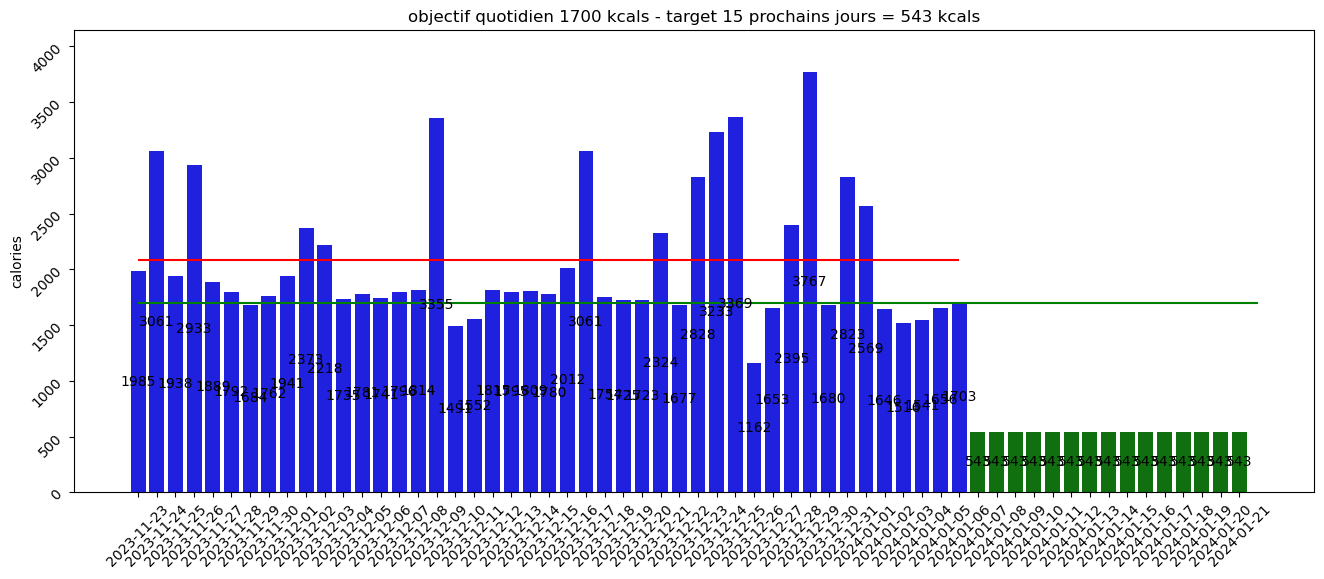

In [41]:
# plot data
fig, ax = plt.subplots(figsize=(16, 6))

tick_label = list(df_food.index[n_jours-PERIODE:]) + [ df_food.index[-1] + datetime.timedelta(days=d) for d in range(1,n_jours+1 )]
listcals = list(df_food['Calories'][n_jours-PERIODE:]) + [ target ] * n_jours

colors = [ 'blue'] * (PERIODE-n_jours) + ['green'] * n_jours
sns.barplot(x=tick_label, y=listcals, ax=ax, palette=colors)

# annotate
ax.bar_label(ax.containers[0], label_type='center', fmt="%.0f")
ax.tick_params(labelrotation=45)

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

ax.set_ylabel('calories')
ax.set_title(f'objectif quotidien {MAX_CAL:.0f} kcals - target {n_jours} prochains jours = {target:.0f} kcals')

ax.hlines(y=avg, xmin=0, xmax=PERIODE-n_jours-1, colors=['red'])
ax.hlines(y=MAX_CAL, xmin=0, xmax=PERIODE, colors=['green'])

plt.show()

# Graphes

In [42]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 'cal_deficit',

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [43]:
def plot_general(longueur=15,
                 year=2023,
                 month=11,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

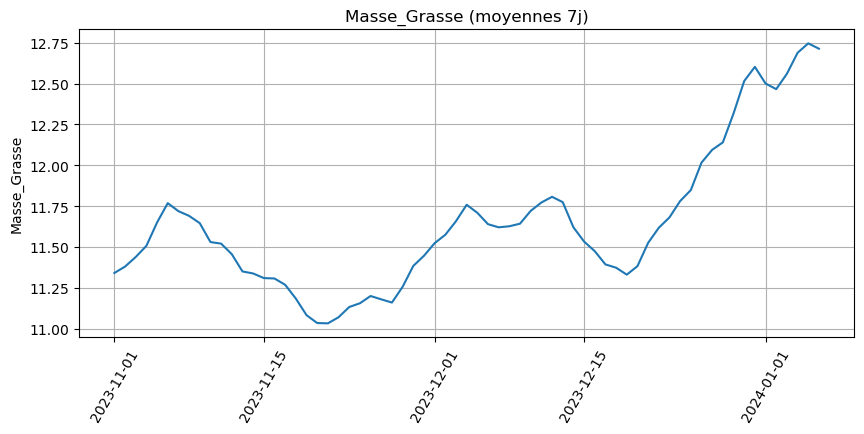

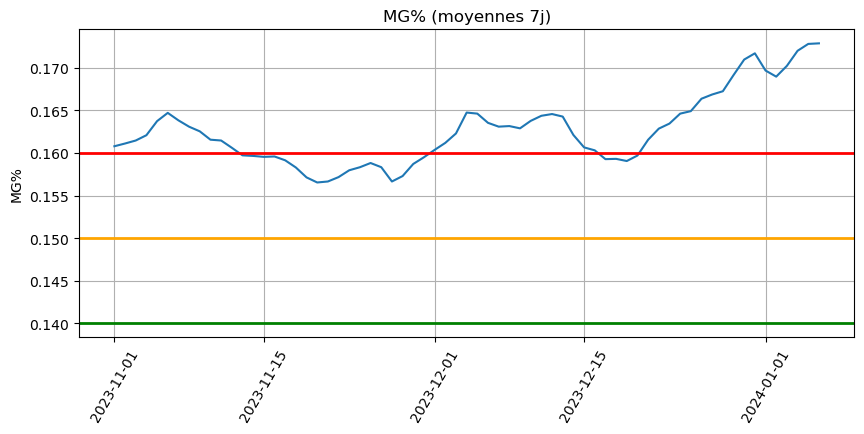

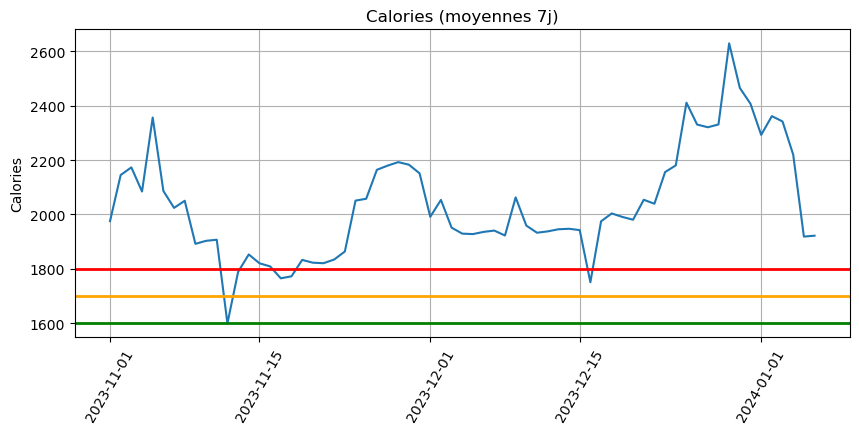

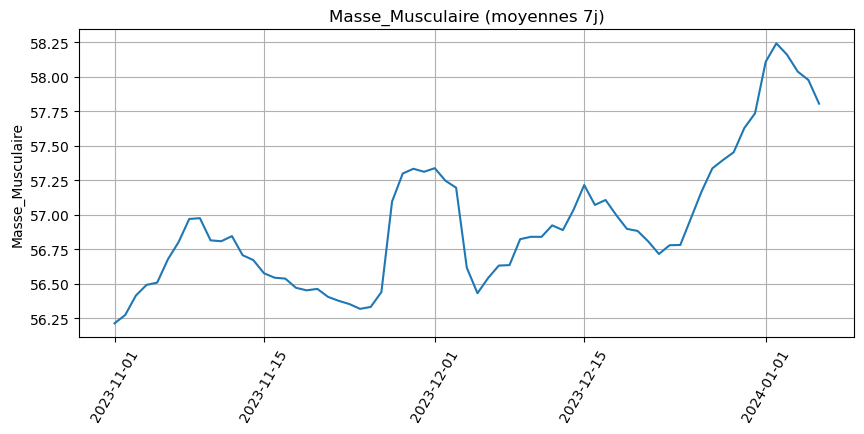

In [44]:
plot_general(longueur=7)

In [45]:
# vars = ['Masse_Grasse', 'MG%', 'Calories','Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire',  'cal_deficit', 

# ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

In [46]:
def plot_general2(longueur=15,
                 year=2023,
                 month=9,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [47]:
# ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [48]:
def plot_general3(longueur=15,
                 year=2023,
                 month=11,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [49]:
# ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [50]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight change (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [51]:
# ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [52]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [53]:
# ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [54]:
def scatter_plot3(mass_interval=5.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly fat mass variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [55]:
ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=5.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot3(mass_interval=5.0, length=15)>